# Module

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix # , precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import pickle
import logging
from collections import defaultdict
import json


RANDOM_SEED = 42
save_data_path = "./results"
os.makedirs(save_data_path, exist_ok=True)

# Class

In [2]:
class data_loader:
    def __init__(self, X_path, sample_annotation_file):
        super().__init__()
        
        self.target_label_name = 'Population code'
        self.notusing_lables = ['IBS,MSL']
        data_split = [0.6, 0.2, 0.2]  # train, val, test

        self.X = np.load(X_path)
        self.sample_annotation_df = pd.read_csv(sample_annotation_file, sep='\t')
        self.y = self.sample_annotation_df[self.target_label_name]
        logging.info(f"[progress] Read data done. X.shape: {self.X.shape}, y.shape: {self.y.shape}")

        self.drop_notusing_sample(notusing_list=self.notusing_lables)
        self.y_encoded, self.label_mapping = self.encode_y()
        self.train_indices, self.val_indices, self.test_indices = self.split_dataset(val_size=data_split[1], test_size=data_split[2])

        logging.info(f" - Data_split: train_set (n={len(self.train_indices)}), val_set (n={len(self.val_indices)}), test_set (n={len(self.test_indices)})")
        assert self.X.shape[0] == self.y.shape[0]
        assert self.X.shape[0] == self.y_encoded.shape[0]
        assert self.test_index_coverage(self.train_indices, self.val_indices, self.test_indices, self.X.shape[0])

    def test_index_coverage(self, train_indices, val_indices, test_indices, total_length):
        combined_indices = np.concatenate((train_indices, val_indices, test_indices))
        unique_indices = np.unique(combined_indices)
        expected_indices = np.arange(total_length)
        if np.array_equal(np.sort(unique_indices), expected_indices):
            return True
        else:
            missing_indices = np.setdiff1d(expected_indices, unique_indices)
            extra_indices = np.setdiff1d(unique_indices, expected_indices)
            print(f"Missing indices: {missing_indices}")
            print(f"Extra indices: {extra_indices}")
            return False

    def drop_notusing_sample(self, notusing_list):
        indices_to_drop = self.sample_annotation_df[self.sample_annotation_df[self.target_label_name].isin(notusing_list)].index
        if not indices_to_drop.empty:
            self.sample_annotation_df = self.sample_annotation_df.drop(indices_to_drop)
            self.y = self.y.drop(indices_to_drop)
            self.X = np.delete(self.X, indices_to_drop, axis=0)
        logging.info(f"[progress] Dropped {len(indices_to_drop)} samples from the dataset. X.shape: {self.X.shape}, y.shape: {self.y.shape}")

    def encode_y(self):
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(self.y)
        label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
        return y_encoded, label_mapping

    def split_dataset(self, val_size=0.15, test_size=0.15):
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=RANDOM_SEED)
        train_val_idx, test_indices = next(sss.split(self.X, self.y_encoded))
        adjusted_val_size = val_size / (1 - test_size)
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=adjusted_val_size, random_state=RANDOM_SEED)
        train_idx, val_idx = next(sss_val.split(self.X[train_val_idx], self.y_encoded[train_val_idx]))
        train_indices = train_val_idx[train_idx]
        val_indices = train_val_idx[val_idx]
        return train_indices, val_indices, test_indices

    def get_data(self):
        return (self.X, np.array(self.y), self.y_encoded), (self.train_indices, self.val_indices, self.test_indices), self.label_mapping

# Data load

Data_data

- merged_support3_random_1M_seed_1204_matrix.npy
- merged_support3_random_1M_seed_42_matrix.npy
- merged_support3_random_1M_seed_919_matrix.npy

test_data

- merged_support3_random_1k_seed_42_matrix.npy

In [3]:
feature_data_path = '/project/datacamp/team11/data' 
# target_feature = "preprocessed/merged_support3_random_1k_seed_42" 

# target_feature = 'preprocessed/merged_support3_random_1M_seed_42' # original
# target_feature = 'preprocessed/merged_support3_random_1M_seed_919' # original
# target_feature = 'preprocessed/merged_support3_random_1M_seed_1204' # original

target_feature_suffix = "_matrix.npy"
sample_annotation_file = os.path.join(feature_data_path, "igsr-1000 genomes 30x on grch38.tsv")

dataset = data_loader(os.path.join(feature_data_path, target_feature + target_feature_suffix), 
                      sample_annotation_file)
(X, y_original, y_encoded), (train_indices, val_indices, test_indices), label_mapping = dataset.get_data()



# Model


In [4]:
def train_ML(X_train, y_train, X_val, y_val, X_test, params):
    model = SVC(C=params['C'], kernel=params['kernel'], random_state=42)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    return y_pred_train, y_pred_val, y_pred_test

params = {'C': 0.1, 'kernel': 'linear'}

X_train, X_val, X_test = X[train_indices], X[val_indices], X[test_indices]
y_train, y_val, y_test = y_encoded[train_indices], y_encoded[val_indices], y_encoded[test_indices]

y_pred_train, y_pred_val, y_pred_test = train_ML(X_train, y_train, X_val, y_val, X_test, params)

print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train)}")
print(f"Val Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test)}")


Train Accuracy: 1.0
Val Accuracy: 0.9078125
Test Accuracy: 0.8970358814352574


# Preprocess

In [5]:
def calculate_accuracy_by_country(y_true, y_pred, y_original, label_mapping):
    accuracy_dict = defaultdict(dict)
    y_true_dict = defaultdict(list)
    y_pred_dict = defaultdict(list)
    
    for country_code, country_name in label_mapping.items():
        indices = np.where(y_original == country_name)[0]
        y_true_country = y_true[indices]
        y_pred_country = y_pred[indices]
        
        accuracy_dict[country_name]['accuracy'] = accuracy_score(y_true_country, y_pred_country)
        accuracy_dict[country_name]['indices'] = indices.tolist()
        
        y_true_dict[country_name] = y_true_country.tolist()
        y_pred_dict[country_name] = y_pred_country.tolist()
    
    return accuracy_dict, y_true_dict, y_pred_dict

train_accuracy_by_country, train_y_true_by_country, train_y_pred_by_country = calculate_accuracy_by_country(y_train, y_pred_train, y_original[train_indices], label_mapping)
val_accuracy_by_country, val_y_true_by_country, val_y_pred_by_country = calculate_accuracy_by_country(y_val, y_pred_val, y_original[val_indices], label_mapping)
test_accuracy_by_country, test_y_true_by_country, test_y_pred_by_country = calculate_accuracy_by_country(y_test, y_pred_test, y_original[test_indices], label_mapping)

print(f"Train Accuracy by Country: {train_accuracy_by_country}")
print(f"Val Accuracy by Country: {val_accuracy_by_country}")
print(f"Test Accuracy by Country: {test_accuracy_by_country}")

print(f"Test y_true by Country: {test_y_true_by_country}")
print(f"Test y_pred by Country: {test_y_pred_by_country}")


Train Accuracy by Country: defaultdict(<class 'dict'>, {'ACB': {'accuracy': 1.0, 'indices': [44, 60, 61, 63, 76, 89, 99, 106, 167, 179, 191, 207, 220, 247, 271, 304, 309, 327, 342, 356, 359, 396, 404, 406, 419, 508, 586, 592, 668, 669, 691, 704, 707, 724, 818, 826, 832, 839, 846, 851, 864, 892, 925, 927, 941, 967, 985, 1032, 1072, 1111, 1244, 1275, 1348, 1376, 1434, 1458, 1476, 1480, 1499, 1517, 1527, 1529, 1552, 1622, 1634, 1686, 1710, 1779, 1780, 1829]}, 'ASW': {'accuracy': 1.0, 'indices': [17, 26, 32, 47, 110, 131, 196, 257, 273, 277, 325, 380, 431, 491, 494, 496, 530, 620, 738, 764, 804, 840, 872, 961, 994, 1012, 1042, 1069, 1073, 1125, 1154, 1176, 1216, 1232, 1282, 1307, 1487, 1512, 1643, 1645, 1748, 1776, 1792, 1835]}, 'BEB': {'accuracy': 1.0, 'indices': [7, 11, 34, 36, 38, 45, 57, 68, 74, 120, 146, 168, 171, 230, 250, 258, 272, 274, 298, 317, 334, 360, 382, 408, 436, 462, 482, 497, 518, 532, 673, 687, 690, 708, 733, 769, 795, 831, 873, 889, 915, 920, 981, 1023, 1053, 1081, 1088,

In [6]:
def save_accuracy_by_country(filename, test_y_pred_by_country, test_y_true_by_country, train_acc, val_acc, test_acc):
    results = {
        'train': train_acc,
        'val': val_acc,
        'test': test_acc,
        'y_pred':test_y_pred_by_country,
        'y_test':test_y_true_by_country
    }
    with open(filename, 'w') as f:
        json.dump(results, f)


# Save_data

In [75]:
# 1M_seed_42_save_data
# 1M_seed_919_save_data
# 1M_seed_1204_save_data

save_accuracy_by_country('1M_seed_1204_save_data.json', test_y_pred_by_country, test_y_true_by_country, train_accuracy_by_country, val_accuracy_by_country, test_accuracy_by_country)

with open('1M_seed_1204_save_data.json', 'r') as f:
    loaded_results = json.load(f)
    
print(f"Loaded Results: {loaded_results}")

Loaded Results: {'train': {'ACB': {'accuracy': 1.0, 'indices': [44, 60, 61, 63, 76, 89, 99, 106, 167, 179, 191, 207, 220, 247, 271, 304, 309, 327, 342, 356, 359, 396, 404, 406, 419, 508, 586, 592, 668, 669, 691, 704, 707, 724, 818, 826, 832, 839, 846, 851, 864, 892, 925, 927, 941, 967, 985, 1032, 1072, 1111, 1244, 1275, 1348, 1376, 1434, 1458, 1476, 1480, 1499, 1517, 1527, 1529, 1552, 1622, 1634, 1686, 1710, 1779, 1780, 1829]}, 'ASW': {'accuracy': 1.0, 'indices': [17, 26, 32, 47, 110, 131, 196, 257, 273, 277, 325, 380, 431, 491, 494, 496, 530, 620, 738, 764, 804, 840, 872, 961, 994, 1012, 1042, 1069, 1073, 1125, 1154, 1176, 1216, 1232, 1282, 1307, 1487, 1512, 1643, 1645, 1748, 1776, 1792, 1835]}, 'BEB': {'accuracy': 1.0, 'indices': [7, 11, 34, 36, 38, 45, 57, 68, 74, 120, 146, 168, 171, 230, 250, 258, 272, 274, 298, 317, 334, 360, 382, 408, 436, 462, 482, 497, 518, 532, 673, 687, 690, 708, 733, 769, 795, 831, 873, 889, 915, 920, 981, 1023, 1053, 1081, 1088, 1105, 1185, 1237, 1248, 1301

# Data load for visualization

## Color

In [3]:
colors = ['#F8B195', '#F67280', '#C06C84', '#6C5B7B', '#355C7D', '#99B898']

## Reload

In [4]:
def json_to_dataframe(json_file):
    with open(json_file, 'r') as f:
        results = json.load(f)
    
    data = []
    for phase in ['train', 'val', 'test']:
        for country, metrics in results[phase].items():
            data.append({
                'phase': phase,
                'country': country,
                'accuracy': metrics['accuracy'],
                'indices': metrics['indices']
            })
    
    y_data = []
    for country, y_pred in results['y_pred'].items():
        y_data.append({
            'phase': 'test',
            'country': country,
            'type': 'y_pred',
            'values': y_pred
        })
    for country, y_true in results['y_test'].items():
        y_data.append({
            'phase': 'test',
            'country': country,
            'type': 'y_true',
            'values': y_true
        })

    df_accuracy = pd.DataFrame(data)
    df_y = pd.DataFrame(y_data)
    
    return df_accuracy, df_y


## Single

In [26]:
# 1M_seed_42_save_data
# 1M_seed_919_save_data
# 1M_seed_1204_save_data

df, df_y = json_to_dataframe('1M_seed_42_save_data.json')


### Preprocess_df

In [27]:
df_acc = df[df['phase']=='test']
results_df = df_acc.drop(['phase','indices'], axis=1)
results_df.head()

,country,accuracy
52,ACB,0.434783
53,ASW,0.466667
54,BEB,1.000000
55,CDX,0.894737
56,CEU,1.000000


In [28]:
results_df.reset_index(drop=True, inplace=True)
results_df.head()


,country,accuracy
0,ACB,0.434783
1,ASW,0.466667
2,BEB,1.000000
3,CDX,0.894737
4,CEU,1.000000


In [29]:
sort_results_df = results_df.sort_values(by = 'accuracy', ascending=False)
print(sort_results_df.count())
sort_results_df.head()

country     26
accuracy    26
dtype: int64


,country,accuracy
13,IBS,1.0
9,FIN,1.0
24,TSI,1.0
20,PEL,1.0
18,MSL,1.0


### Barplot & errorbar

/tmp/ipykernel_9993/3609939762.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='country', y='accuracy', data=sort_results_df, ci=None)


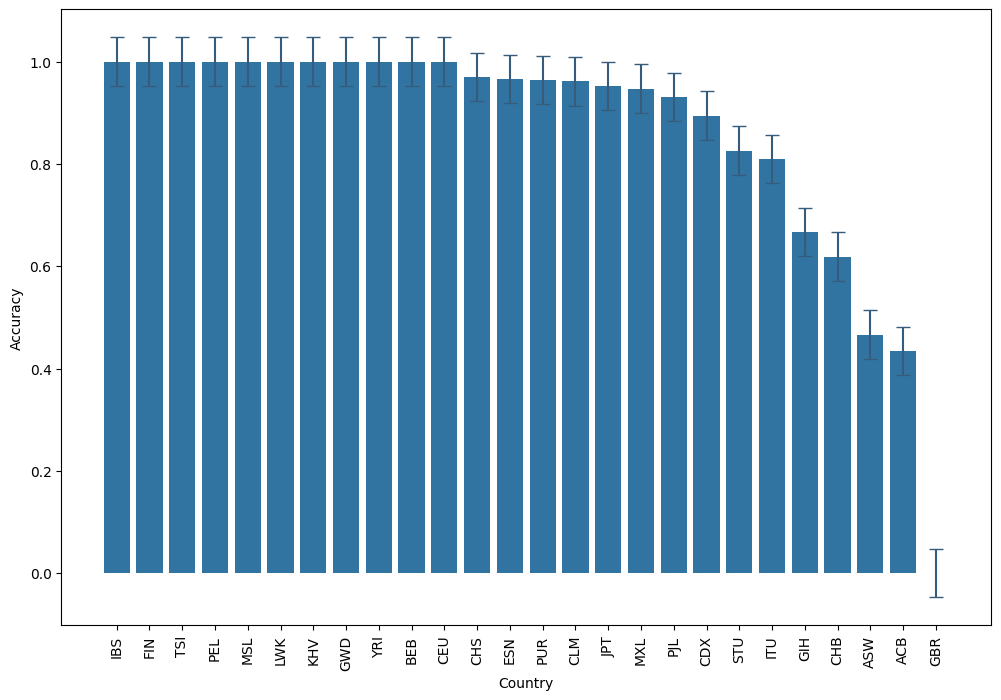

In [30]:
n_samples = 26

sort_results_df['se'] = sort_results_df['accuracy'].std() / np.sqrt(n_samples)


plt.figure(figsize=(12, 8))
sns.barplot(x='country', y='accuracy', data=sort_results_df, ci=None)


plt.errorbar(sort_results_df['country'], sort_results_df['accuracy'], yerr=sort_results_df['se'], fmt='none', color=colors[4], capsize=5)

# save_pdf
plt.savefig('Single_barplot_with_errorbars.pdf', format='pdf')

plt.xlabel('Country')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)  
plt.show()

In [31]:
# 1M_seed_42_save_data
# 1M_seed_919_save_data
# 1M_seed_1204_save_data

df, df_y = json_to_dataframe('1M_seed_42_save_data.json')


In [32]:
df_acc = df[df['phase']=='test']
results_df = df_acc.drop(['phase','indices'], axis=1)
results_df.head()

,country,accuracy
52,ACB,0.434783
53,ASW,0.466667
54,BEB,1.000000
55,CDX,0.894737
56,CEU,1.000000


In [33]:
results_df.reset_index(drop=True, inplace=True)
results_df.head()


,country,accuracy
0,ACB,0.434783
1,ASW,0.466667
2,BEB,1.000000
3,CDX,0.894737
4,CEU,1.000000


In [34]:
sort_results_df = results_df.sort_values(by = 'accuracy', ascending=False)
print(sort_results_df.count())
sort_results_df.head()

country     26
accuracy    26
dtype: int64


,country,accuracy
13,IBS,1.0
9,FIN,1.0
24,TSI,1.0
20,PEL,1.0
18,MSL,1.0


### Preprocess_df_y

In [35]:
df_y.head()
# df_y

,phase,country,type,values
0,test,ACB,y_pred,"[25, 25, 25, 0, 25, 0, 25, 25, 25, 0, 25, 0, 2..."
1,test,ASW,y_pred,"[0, 1, 1, 1, 0, 25, 0, 1, 0, 0, 0, 1, 0, 1, 1]"
2,test,BEB,y_pred,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,test,CDX,y_pred,"[3, 3, 3, 3, 3, 3, 16, 3, 3, 3, 3, 6, 3, 3, 3,..."
4,test,CEU,y_pred,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [36]:
df_y= df_y.drop('phase', axis=1)
df_y.head()


,country,type,values
0,ACB,y_pred,"[25, 25, 25, 0, 25, 0, 25, 25, 25, 0, 25, 0, 2..."
1,ASW,y_pred,"[0, 1, 1, 1, 0, 25, 0, 1, 0, 0, 0, 1, 0, 1, 1]"
2,BEB,y_pred,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,CDX,y_pred,"[3, 3, 3, 3, 3, 3, 16, 3, 3, 3, 3, 6, 3, 3, 3,..."
4,CEU,y_pred,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [37]:
test_df = df_y[df_y['type']=='y_true']
pred_df = df_y[df_y['type']=='y_pred']

test_df = test_df.drop('type', axis=1)
pred_df = pred_df.drop('type', axis=1)

In [38]:
test_df.head()

,country,values
26,ACB,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
27,ASW,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
28,BEB,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
29,CDX,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
30,CEU,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [39]:
pred_df.head()

,country,values
0,ACB,"[25, 25, 25, 0, 25, 0, 25, 25, 25, 0, 25, 0, 2..."
1,ASW,"[0, 1, 1, 1, 0, 25, 0, 1, 0, 0, 0, 1, 0, 1, 1]"
2,BEB,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,CDX,"[3, 3, 3, 3, 3, 3, 16, 3, 3, 3, 3, 6, 3, 3, 3,..."
4,CEU,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [40]:
sort_results_df.country.head()

13    IBS
9     FIN
24    TSI
20    PEL
18    MSL
Name: country, dtype: object

In [41]:
sorted_countries = sort_results_df['country'].values
sorted_countries = pd.DataFrame(sorted_countries)
sorted_countries['sort']=sorted_countries[0]
sorted_countries = sorted_countries.drop(sorted_countries.columns[0], axis=1)
sort_c = sorted_countries
sort_c.head()


,sort
0,IBS
1,FIN
2,TSI
3,PEL
4,MSL


### Confusion_matrix

In [42]:
# flatten
def flatten_values(df):
    flattened_values = []
    for values in df['values']:
        flattened_values.extend(values)
    return flattened_values

y_true = flatten_values(test_df)
y_pred = flatten_values(pred_df)

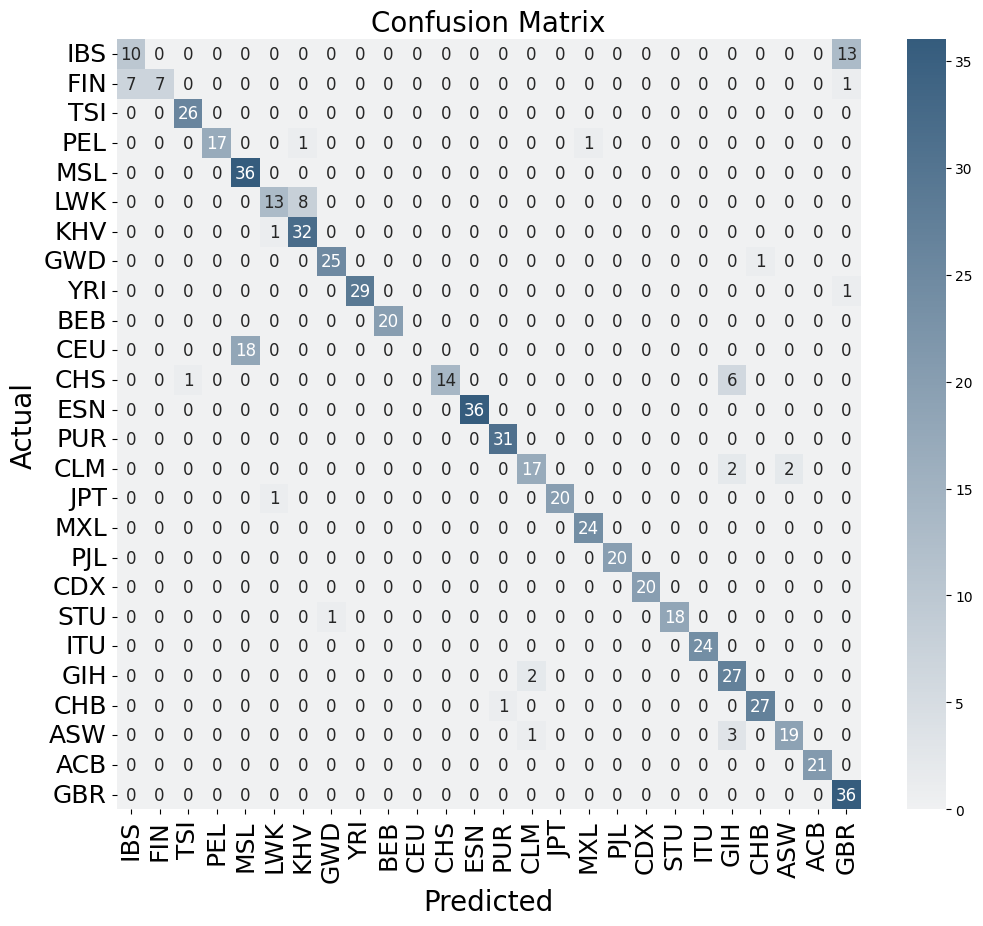

In [43]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))

cmap = sns.light_palette(colors[4], as_cmap=True)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=sort_c['sort'], yticklabels=sort_c['sort'], cmap=cmap, annot_kws={"size": 12})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Confusion Matrix', fontsize=20)

# save_pdf
plt.savefig('Single_Confusion_matrix.pdf', format='pdf')

plt.show()

## Multi

In [5]:
df1, df_y1 = json_to_dataframe('1M_seed_42_save_data.json')
df2, df_y2 = json_to_dataframe('1M_seed_919_save_data.json')
df3, df_y3 = json_to_dataframe('1M_seed_1204_save_data.json')


### Preprocess_df
for barplot & errorbar

In [6]:
df1.head()

,phase,country,accuracy,indices
0,train,ACB,1.0,"[44, 60, 61, 63, 76, 89, 99, 106, 167, 179, 19..."
1,train,ASW,1.0,"[17, 26, 32, 47, 110, 131, 196, 257, 273, 277,..."
2,train,BEB,1.0,"[7, 11, 34, 36, 38, 45, 57, 68, 74, 120, 146, ..."
3,train,CDX,1.0,"[75, 85, 111, 125, 129, 226, 280, 371, 378, 38..."
4,train,CEU,1.0,"[12, 35, 39, 69, 79, 87, 123, 148, 155, 157, 1..."


In [7]:
combined_df = pd.concat([df1, df2, df3])
mean_acc_df = combined_df.groupby('country').agg({'accuracy': ['mean', 'std']}).reset_index()
mean_acc_df.columns = ['country', 'mean_accuracy', 'std_accuracy']
mean_acc_df.head(10)

,country,mean_accuracy,std_accuracy
0,ACB,0.705314,0.240881
1,ASW,0.681481,0.248948
2,BEB,1.000000,0.000000
3,CDX,0.939571,0.050981
4,CEU,1.000000,0.000000
5,CHB,0.740741,0.204971
6,CHS,0.993266,0.013362
7,CLM,0.991453,0.016960
8,ESN,0.974074,0.022222
9,FIN,0.994444,0.016667


In [8]:
mean_acc_df = mean_acc_df.sort_values(by = 'mean_accuracy', ascending=False)
print(mean_acc_df.count())
mean_acc_df.head()

country          26
mean_accuracy    26
std_accuracy     26
dtype: int64


,country,mean_accuracy,std_accuracy
13,IBS,1.0,0.0
2,BEB,1.0,0.0
20,PEL,1.0,0.0
4,CEU,1.0,0.0
18,MSL,1.0,0.0


### Barplot & errorbar

/tmp/ipykernel_9993/749898634.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='country', y='mean_accuracy', data=mean_acc_df, ci=None)


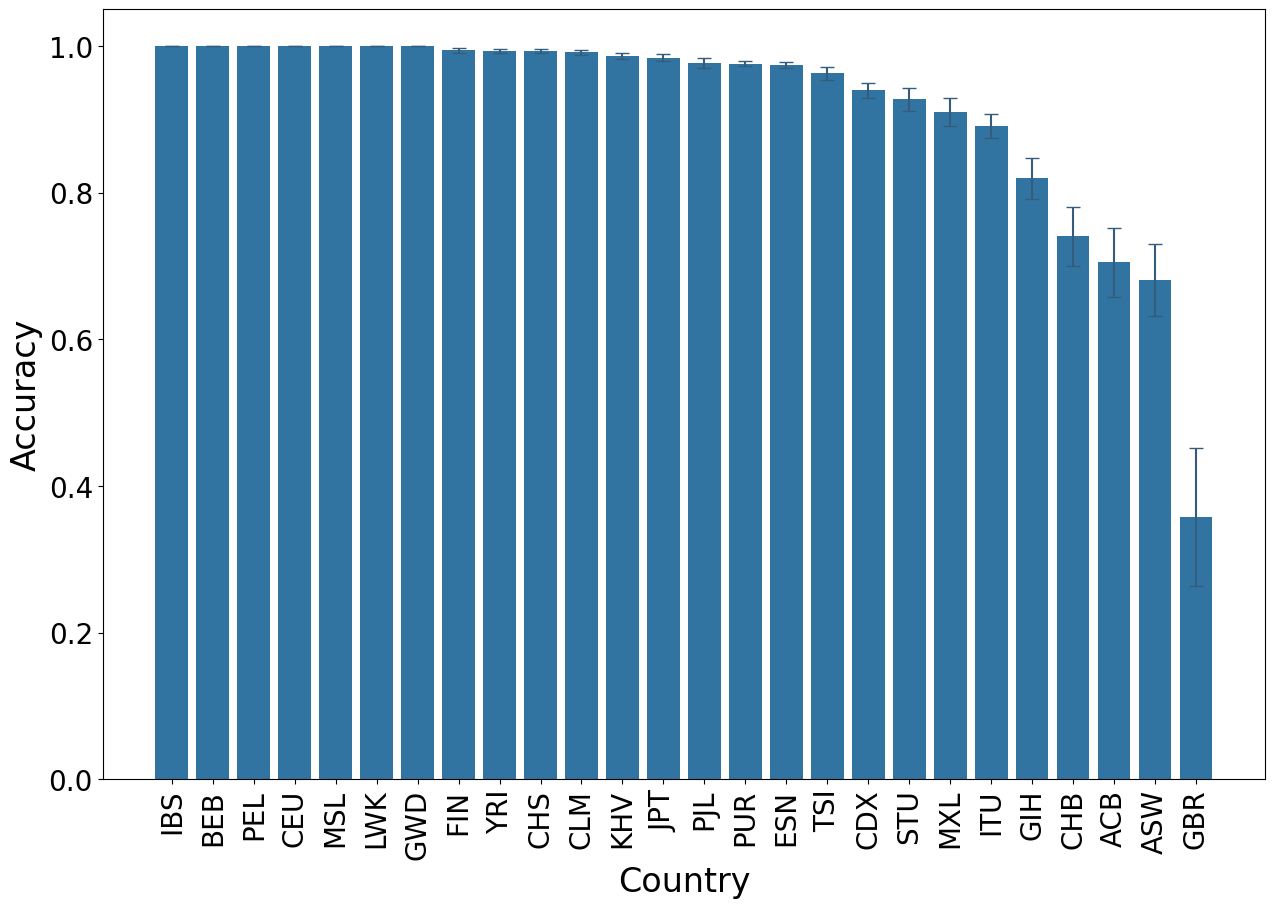

In [44]:
n_samples = 26

mean_acc_df['se'] = mean_acc_df['std_accuracy'] / np.sqrt(n_samples)


plt.figure(figsize=(15, 10))
sns.barplot(x='country', y='mean_accuracy', data=mean_acc_df, ci=None)

plt.errorbar(mean_acc_df['country'], mean_acc_df['mean_accuracy'], 
             yerr=mean_acc_df['se'], fmt='none', color=colors[4], capsize=5)

plt.xlabel('Country', fontsize=24)
plt.ylabel('Accuracy', fontsize=24)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20) 

# save_pdf
plt.savefig('Multi_barplot_with_errorbars.pdf', format='pdf')

plt.show()

### preprocess_df_y
for Confusion matrix

In [10]:
df_y1.head()

,phase,country,type,values
0,test,ACB,y_pred,"[25, 25, 25, 0, 25, 0, 25, 25, 25, 0, 25, 0, 2..."
1,test,ASW,y_pred,"[0, 1, 1, 1, 0, 25, 0, 1, 0, 0, 0, 1, 0, 1, 1]"
2,test,BEB,y_pred,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,test,CDX,y_pred,"[3, 3, 3, 3, 3, 3, 16, 3, 3, 3, 3, 6, 3, 3, 3,..."
4,test,CEU,y_pred,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [11]:
df_y2.head()

,phase,country,type,values
0,test,ACB,y_pred,"[25, 25, 25, 0, 25, 0, 25, 25, 25, 0, 25, 0, 2..."
1,test,ASW,y_pred,"[0, 1, 1, 1, 0, 25, 0, 1, 0, 0, 0, 1, 0, 1, 0]"
2,test,BEB,y_pred,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,test,CDX,y_pred,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, ..."
4,test,CEU,y_pred,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [12]:
df_y3.head()

,phase,country,type,values
0,test,ACB,y_pred,"[0, 25, 25, 0, 25, 0, 25, 25, 25, 0, 25, 0, 25..."
1,test,ASW,y_pred,"[0, 1, 1, 1, 0, 25, 0, 1, 0, 0, 0, 1, 0, 1, 1]"
2,test,BEB,y_pred,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,test,CDX,y_pred,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, ..."
4,test,CEU,y_pred,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [13]:
df_y1= df_y1.drop('phase', axis=1)
df_y2= df_y2.drop('phase', axis=1)
df_y3= df_y3.drop('phase', axis=1)

df_y3.head()

,country,type,values
0,ACB,y_pred,"[0, 25, 25, 0, 25, 0, 25, 25, 25, 0, 25, 0, 25..."
1,ASW,y_pred,"[0, 1, 1, 1, 0, 25, 0, 1, 0, 0, 0, 1, 0, 1, 1]"
2,BEB,y_pred,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,CDX,y_pred,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, ..."
4,CEU,y_pred,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [14]:
test_df1 = df_y1[df_y1['type']=='y_true']
pred_df1 = df_y1[df_y1['type']=='y_pred']

test_df1 = test_df1.drop('type', axis=1)
pred_df1 = pred_df1.drop('type', axis=1)

test_df2 = df_y2[df_y2['type']=='y_true']
pred_df2 = df_y2[df_y2['type']=='y_pred']

test_df2 = test_df2.drop('type', axis=1)
pred_df2 = pred_df2.drop('type', axis=1)

test_df3 = df_y3[df_y3['type']=='y_true']
pred_df3 = df_y3[df_y3['type']=='y_pred']

test_df3 = test_df3.drop('type', axis=1)
pred_df3 = pred_df3.drop('type', axis=1)

In [17]:
test_df3.head()

,country,values
26,ACB,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
27,ASW,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
28,BEB,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
29,CDX,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
30,CEU,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [18]:
pred_df3.head()

,country,values
0,ACB,"[0, 25, 25, 0, 25, 0, 25, 25, 25, 0, 25, 0, 25..."
1,ASW,"[0, 1, 1, 1, 0, 25, 0, 1, 0, 0, 0, 1, 0, 1, 1]"
2,BEB,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,CDX,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, ..."
4,CEU,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


### Sort_country

In [19]:
mean_acc_df.country.head()

13    IBS
2     BEB
20    PEL
4     CEU
18    MSL
Name: country, dtype: object

In [20]:
sorted_countries = mean_acc_df.country.values
sorted_countries = pd.DataFrame(sorted_countries)
sorted_countries['sort']=sorted_countries[0]
sorted_countries = sorted_countries.drop(sorted_countries.columns[0], axis=1)
sorted_countries.head()


,sort
0,IBS
1,BEB
2,PEL
3,CEU
4,MSL


### Confusion_matrix

In [21]:
# flatten
def flatten_values(df):
    flattened_values = []
    for values in df['values']:
        flattened_values.extend(values)
    return flattened_values

y_true1 = flatten_values(test_df1)
y_pred1 = flatten_values(pred_df1)

y_true2 = flatten_values(test_df2)
y_pred2 = flatten_values(pred_df2)

y_true3 = flatten_values(test_df3)
y_pred3 = flatten_values(pred_df3)

In [22]:
cm1 = confusion_matrix(y_true1, y_pred1)
cm2 = confusion_matrix(y_true2, y_pred2)
cm3 = confusion_matrix(y_true3, y_pred3)

cm_avg = (cm1 + cm2 + cm3) / 3

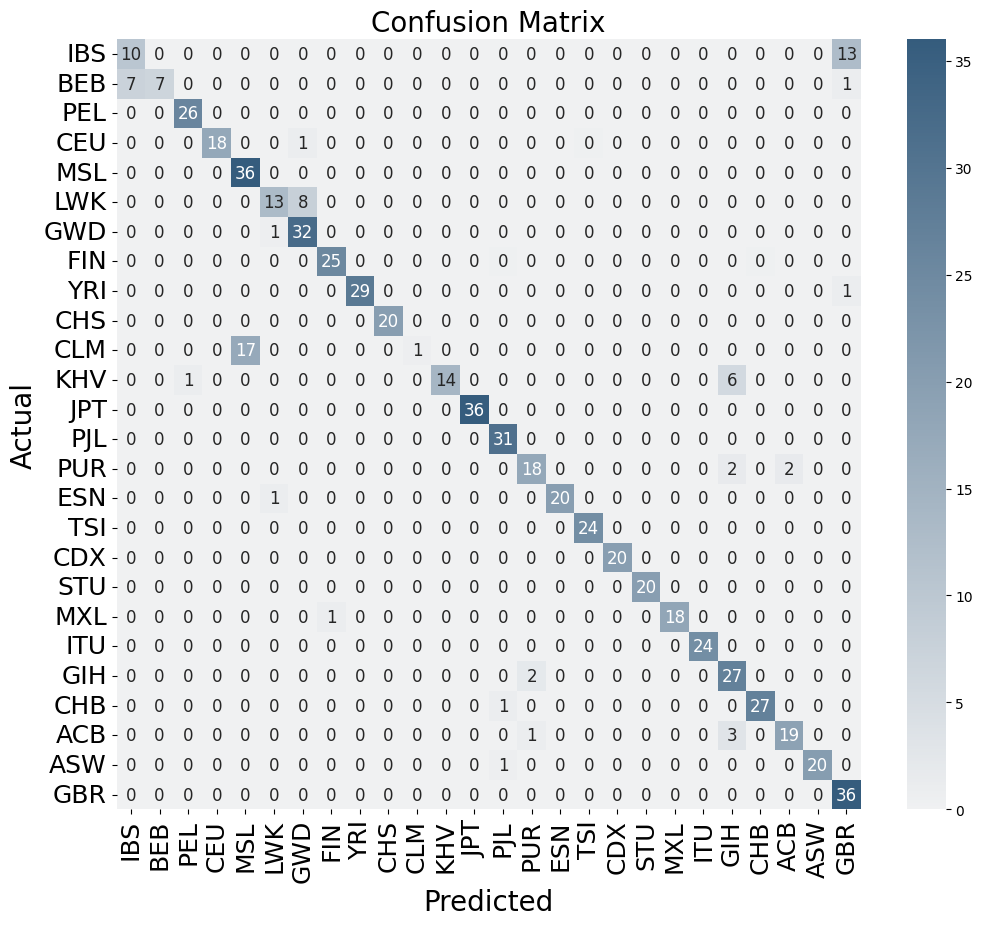

In [24]:
plt.figure(figsize=(12, 10))

cmap = sns.light_palette(colors[4], as_cmap=True)

sns.heatmap(cm_avg, annot=True, fmt='.0f', xticklabels=sorted_countries['sort'], yticklabels=sorted_countries['sort'],
            cmap=cmap, annot_kws={"size": 12})

plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Confusion Matrix', fontsize=20)

# save_pdf
plt.savefig('Multi_Confusion_matrix.pdf', format='pdf')

plt.show()